In [ ]:
!pip install optuna

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import optuna
from optuna import Trial
from optuna.samplers import RandomSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [78]:
train_df = pd.read_csv(
    "/content/drive/MyDrive/final project/train.csv/train.csv", index_col="id")

EDA

In [79]:
train_df['product_code'].value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

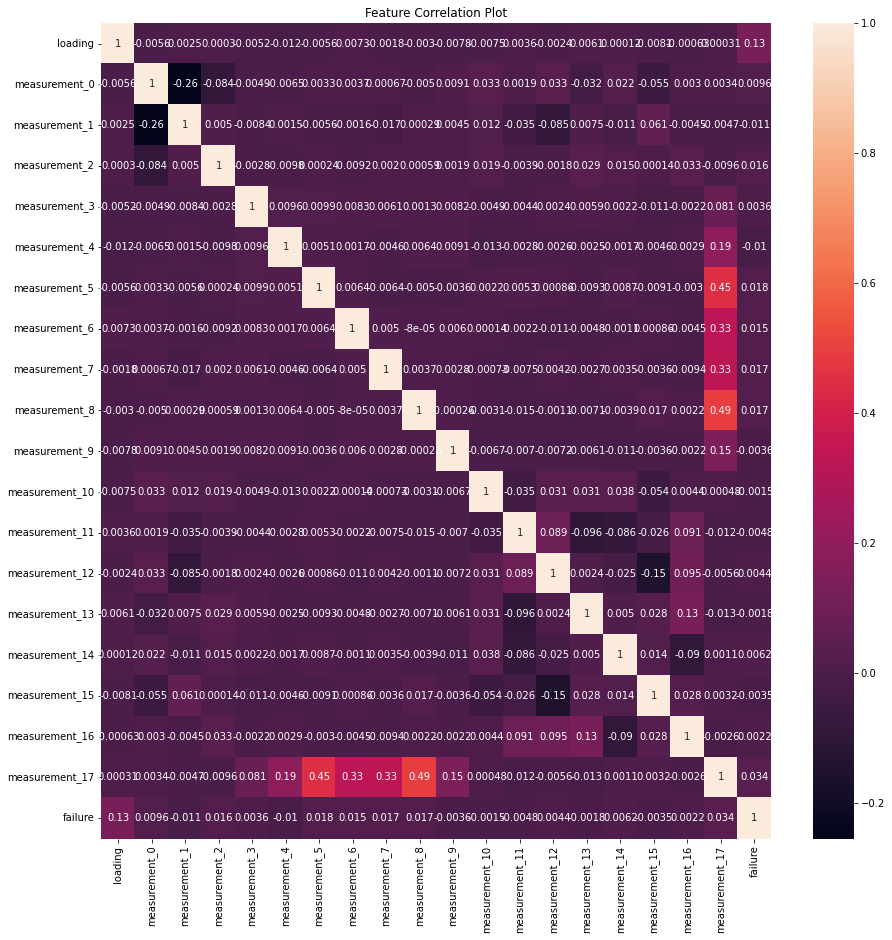

In [80]:
categorical_cols = [
    'product_code', "attribute_0", "attribute_1", "attribute_2", "attribute_3"]
numerical_cols = [
    col for col in train_df.columns if col not in categorical_cols]
plt.figure(figsize=(15, 15))
plt.title('Feature Correlation Plot')
sns.heatmap(train_df[numerical_cols].corr(), annot=True)
plt.show()

In [81]:
# string and int column are complete
pd.DataFrame(
    [train_df.dtypes, train_df.isna().sum()], index=["dtype", "missing"]).T

,dtype,missing
product_code,object,0
loading,float64,250
attribute_0,object,0
attribute_1,object,0
attribute_2,int64,0
attribute_3,int64,0
measurement_0,int64,0
measurement_1,int64,0
measurement_2,int64,0
measurement_3,float64,381


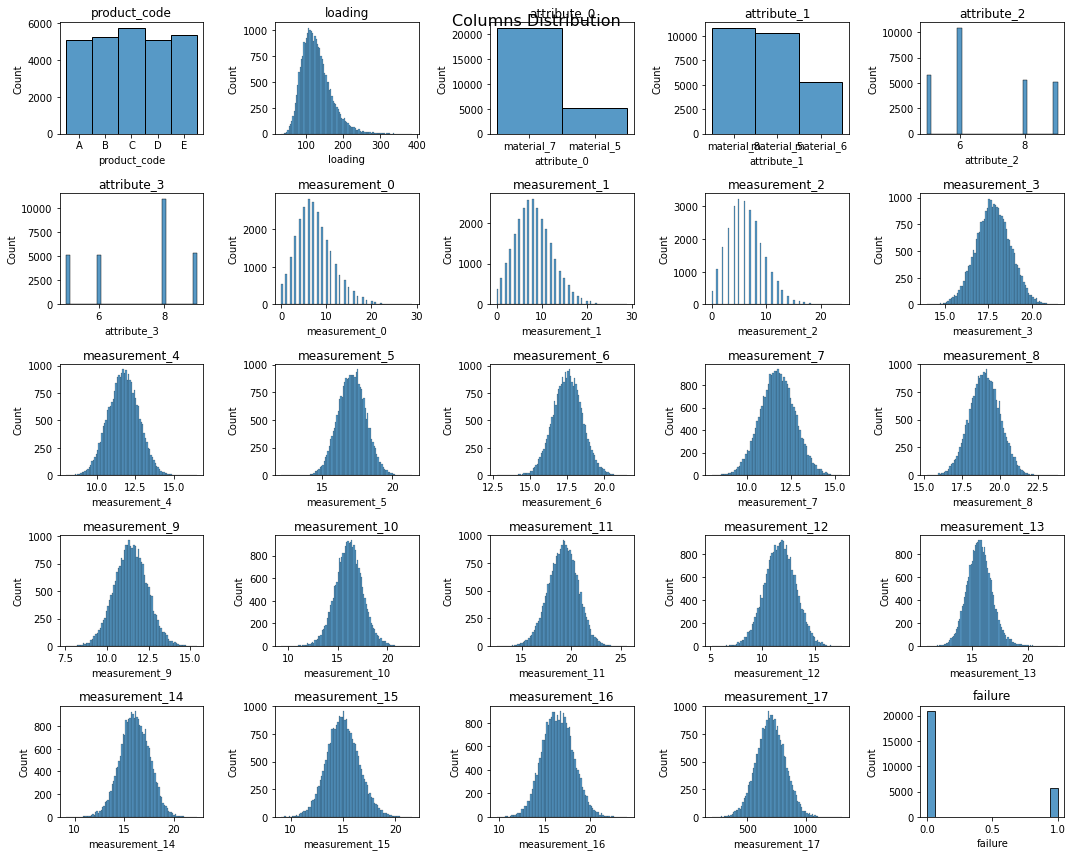

In [82]:
# plot distribution of each feature
plt.figure(figsize=(15, 12))
plt.suptitle('Columns Distribution', fontsize=16)
for i, col in enumerate(train_df.columns):
    ax = plt.subplot(5, 5, i+1)
    sns.histplot(train_df[col], ax=ax)
    plt.title(col)
plt.tight_layout()

Preprocessing

In [83]:
def data_process(data):
    # referred to
    # https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/343368
    # checking missing values of M3 and M5
    data['withM3'] = data.measurement_3.isna()
    data['withM5'] = data.measurement_5.isna()
    data['withM3&M5'] = data['withM3'] * data['withM5']   
    # referred to
    # https://www.kaggle.com/code/samuelcortinhas/tps-aug-22-failure-prediction
    # do one-hot encoding
    materials = ['attribute_0', 'attribute_1']
    for col in materials:
        dummies = pd.get_dummies(data[col], prefix=col)
        data = data.merge(dummies, left_index=True, right_index=True)
    data = data.drop(materials, axis=1)
    data = data.drop('attribute_1_material_8', axis=1)
    # product's width and height
    data['2*3'] = data['attribute_2'] * data['attribute_3']
    data = data.drop(['attribute_2', 'attribute_3'], axis=1)
    # fill loading and measurement's nan  with IterativeImputer:
    # referred to 
    # https://www.kaggle.com/code/samuelcortinhas/tps-aug-22-failure-prediction#1.-Introduction
    # impute by product_code
    features = [
        f for f in data.columns 
        if f.startswith('measurement') or f == 'loading']
    frames = []
    for code in data.product_code.unique():
        df = data[data.product_code == code].copy()
        imputer = IterativeImputer(
            max_iter=50, random_state=0, 
            skip_complete=True, n_nearest_features=12)
        imputer.fit(df[features])
        df[features] = imputer.transform(df[features])
        frames.append(df)
    data = pd.concat(frames)
    # referred to
    # https://www.kaggle.com/code/desalegngeb/tps08-logisticregression-and-some-fe
    data['measurement_avg'] = data[
        [f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)
    data = data.drop([f'measurement_{i}' for i in range(3, 17)], axis=1)
    # scale data to use logistic regression
    scaler = StandardScaler()
    columns = [
        a for a in data.columns 
        if a not in ['product_code', 'isTrain', 'failure', 'withM3', 'withM5']]
    data[columns] = scaler.fit_transform(data[columns])
    return data


train_df = data_process(train_df)

/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Comparing models and choose the best algorithm

In [84]:
train_list = []
test_list = []
N = 5
train_dfs = train_df.copy()
train_df['cat_failure'] = train_df['product_code'].astype(str)
+ train_df['failure'].astype(str)
kfold = StratifiedKFold(n_splits=N, random_state=0, shuffle=True)
X = train_df.drop('cat_failure', axis=1)
y = train_df['cat_failure']
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = X.iloc[train_index].failure, X.iloc[test_index].failure
    train_list.append((X_train, y_train))
    test_list.append((X_test, y_test))

In [85]:
scores = []
for i in range(0, N):
    y_train = train_list[i][1]
    X_train = train_list[i][0].drop(['product_code', 'failure'], axis=1)
    y_test = test_list[i][1]
    X_test = test_list[i][0].drop(['product_code', 'failure'], axis=1)
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(splitter='random',))
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    scores.append(score)
    print(f'FOLD {i}: {score}')
print('')
print(f' Total Average: {np.mean(scores)}')
cv_scores = dict()
cv_scores[f'AdaboostExtraTree'] = np.mean(scores)

FOLD 0: 0.506406829243689
FOLD 1: 0.5077138669835194
FOLD 2: 0.49936369711397904
FOLD 3: 0.5109794542655467
FOLD 4: 0.5097984038480228

 Total Average: 0.5068524502909513


In [86]:
scores = []
for i in range(0, N):
    y_train = train_list[i][1]
    X_train = train_list[i][0].drop(['product_code', 'failure'], axis=1)
    y_test = test_list[i][1]
    X_test = test_list[i][0].drop(['product_code', 'failure'], axis=1)
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    scores.append(score)
    print(f'FOLD {i}: {score}')
print('')
print(f' Total Average: {np.mean(scores)}')
cv_scores[f'RandomForestClassifier'] = np.mean(scores)

FOLD 0: 0.5428199001336594
FOLD 1: 0.5530411819996643
FOLD 2: 0.532080461930418
FOLD 3: 0.5543987525200548
FOLD 4: 0.5511723376375114

 Total Average: 0.5467025268442616


In [87]:
scores = []
for i in range(0, N):
    y_train = train_list[i][1]
    X_train = train_list[i][0].drop(['product_code', 'failure'], axis=1)
    y_test = test_list[i][1]
    X_test = test_list[i][0].drop(['product_code', 'failure'], axis=1)
    model = XGBRFClassifier(
        tree_method='exact', eval_metric='logloss', num_parallel_tree=100)
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    scores.append(score)
    print(f'FOLD {i}: {score}')

print('')
print(f' Total Average: {np.mean(scores)}')
cv_scores[f'XGBRFClassifier'] = np.mean(scores)

FOLD 0: 0.5758476660025723
FOLD 1: 0.5975289259311257
FOLD 2: 0.5802274151108883
FOLD 3: 0.593461608982126
FOLD 4: 0.5930977587018904

 Total Average: 0.5880326749457205


In [88]:
scores = []
for i in range(0, N):
    y_train = train_list[i][1]
    X_train = train_list[i][0].drop(['product_code', 'failure'], axis=1)
    y_test = test_list[i][1]
    X_test = test_list[i][0].drop(['product_code', 'failure'], axis=1)
    model = LGBMClassifier(
        boosting_type='rf', metric='logloss', colsample_bynode=0.8,
        subsample=0.8, subsample_freq=1, extra_trees=True)
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    scores.append(score)
    print(f'FOLD {i}: {score}')

print('')
print(f' Total Average: {np.mean(scores)}')
cv_scores[f'LGBMClassifier'] = np.mean(scores)

FOLD 0: 0.5725109071192596
FOLD 1: 0.5966496555254606
FOLD 2: 0.5775735079146306
FOLD 3: 0.5919448232624085
FOLD 4: 0.5928686843013018

 Total Average: 0.5863095156246123


In [89]:
scores = []
for i in range(0, N):
    y_train = train_list[i][1]
    X_train = train_list[i][0].drop(['product_code', 'failure'], axis=1)
    y_test = test_list[i][1]
    X_test = test_list[i][0].drop(['product_code', 'failure'], axis=1)
    model = LogisticRegression(
        max_iter=250, C=0.1, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    scores.append(score)
    print(f'FOLD {i}: {score}')

print('')
print(f' Total Average: {np.mean(scores)}')
cv_scores[f'LogisticRegression'] = np.mean(scores)

FOLD 0: 0.5808841701762791
FOLD 1: 0.6011500176346309
FOLD 2: 0.578371966754375
FOLD 3: 0.5975565396373149
FOLD 4: 0.5953339306710865

 Total Average: 0.5906593249747373


In [90]:
cv_score = pd.DataFrame(cv_scores, index=['avg'])
cv_score

,AdaboostExtraTree,RandomForestClassifier,XGBRFClassifier,LGBMClassifier,LogisticRegression
avg,0.506852,0.546703,0.588033,0.58631,0.590659


Dealing with imbalanced datas -> smote

In [91]:
train_data = train_dfs.copy()
train_dfs['product_code'] = [ord(i) for i in train_dfs['product_code']]

In [92]:
from imblearn.over_sampling import SMOTE
X = train_dfs.drop(['failure'], axis=1)
Y = train_dfs['failure']

sm = SMOTE(k_neighbors=143)
X_new, Y_new = sm.fit_resample(X, Y)
X_new['failure'] = Y_new

In [93]:
train_dfs = X_new
train_dfs['product_code'] = [chr(i) for i in train_dfs['product_code']]

In [94]:
train_dfs.failure.value_counts()

0    20921
1    20921
Name: failure, dtype: int64

Choose 5 important features

In [95]:
train_list = []
test_list = []
N = 5
train_dfs['cat_failure'] = train_dfs['product_code'].astype(str)
+ train_dfs['failure'].astype(str)
kfold = StratifiedKFold(
    n_splits=N, random_state=0, shuffle=True)
X = train_dfs.drop('cat_failure', axis=1)
y = train_dfs['cat_failure']
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = X.iloc[train_index].failure, X.iloc[test_index].failure
    train_list.append((X_train, y_train))
    test_list.append((X_test, y_test))

In [96]:
scores = []
fis2 = []
for i in range(0, N):
    y_train = train_list[i][1]
    X_train = train_list[i][0].drop(['product_code', 'failure'], axis=1)
    y_test = test_list[i][1]
    X_test = test_list[i][0].drop(['product_code', 'failure'], axis=1)
    model = LogisticRegression(
        max_iter=250, C=0.1, penalty='l1', solver='liblinear')
    # Fit model
    model.fit(X_train, y_train)
    # create a feature importancedataframe
    fi = pd.DataFrame(
        index=model.feature_names_in_,
        data=model.coef_[0], columns=[f'{i}_importance'])
    fis2.append(fi)
    # Get predictions
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    scores.append(score)
    print(f'FOLD {i}: {score}')

print('')
print(f' Total Average: {np.mean(scores)}')

FOLD 0: 0.6038772817618971
FOLD 1: 0.5981082356328273
FOLD 2: 0.6029241773501876
FOLD 3: 0.5865106050558335
FOLD 4: 0.593783215848309

 Total Average: 0.5970407031298108


In [97]:
fis2_df = pd.concat(fis2, axis=1)
a = fis2_df.sum(axis=1)
a = a.abs().sort_values(ascending=False)
a

withM5                    2.534256
loading                   1.550390
measurement_17            0.445112
measurement_1             0.178416
measurement_2             0.163968
attribute_1_material_6    0.111323
attribute_0_material_5    0.104382
withM3                    0.093530
measurement_avg           0.081801
attribute_0_material_7    0.057786
withM3&M5                 0.044510
attribute_1_material_5    0.033315
2*3                       0.006404
measurement_0             0.002446
dtype: float64

In [98]:
rgb_features = a[:5].index
rgb_features

Index(['withM5', 'loading', 'measurement_17', 'measurement_1',
       'measurement_2'],
      dtype='object')

Choosing hyperparameters(penalty = l1 works better) -> optuna

In [ ]:
def objective(trial):
    auc_scores = []
    for i in range(0, N):
        y_train = train_list[i][1]
        X_train = train_list[i][0][rgb_features]
        y_test = test_list[i][1]
        X_test = test_list[i][0][rgb_features]
        penalty = trial.suggest_categorical('penalty', ["l1"])
        c = trial.suggest_loguniform("C", 1e-3, 1e1)
        solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
        model = LogisticRegression(
            penalty=penalty, C=c, solver=solver, random_state=0, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_scores.append(auc(fpr, tpr))
    return sum(auc_scores) / len(auc_scores)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(
    sampler=RandomSampler(seed=10), direction="maximize")
study.optimize(objective, n_trials=100)

In [75]:
print('Best trial: score {}, params {}'.format(
    study.best_trial.value, study.best_trial.params))

Best trial: score 0.5939954133217078, params {'penalty': 'l1', 'C': 0.018921011773659426, 'solver': 'saga'}



In [ ]:
tuned_model = LogisticRegression(**study.best_trial.params)
tuned_model.fit(
    X.drop(['product_code','failure'], axis=1), X["failure"])
torch.save(tuned_model, "/content/drive/MyDrive/final project/model")